# Fine-tuning DETR on TACO
- Official DETR repository: https://github.com/facebookresearch/detr
- Optimizer: AdamW or LaProp
- Number of class: 6 (paper, metals and plastics, bio, other, non-recycle, glass) or 1 (litter)
- Backbone: ResNet50
- Num queries: 100 (like in official Detr it coressponds to max number of instances per images - this should not be changed if we finetuned)
- Eos coef: 0.1 (like in official Detr mean number of instances per image - this should not be changed if we finetuned)
- 1300 epochs at lr 1e-4 with lr_drop to 1e-5 at 1000

## TACO
- Relatively small with ~1k Train, 150 validation images
- To contrast The COCO dataset is an excellent object detection dataset with 80 classes, 80,000 training images and 40,000 validation images

### 1. Prepared coco annotations with two modes:
- 1 class - litter
- 6 classes - paper, metals and plastics, bio, other, non-recycle, glass

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from shutil import copyfile
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
dataDir='/dih4/dih4_2/wimlds/smajchrowska/TACO_split'
dataType='val'
annFile='{}/annotations/wimlds_{}.json'.format(dataDir,dataType)

In [3]:
#annFile='/dih4/dih4_2/wimlds/smajchrowska/TACO_split/annotations/raw_all.json' 
#dataDir = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/annotatedImage'

In [4]:
#annFile='/dih4/dih4_2/wimlds/TACO-master/data/annotations.json'
#dataDir = '/dih4/dih4_2/wimlds/TACO-master/data'

In [5]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(nms)))

COCO categories: 
Glass, Metals and plastics, Non recyclable, Other, Paper, Bio

COCO supercategories: 
Litter


Image n°82
Image name: /dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/000811.jpg


(-0.5, 3263.5, 2447.5, -0.5)

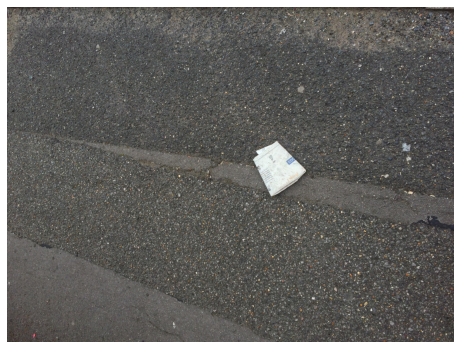

In [7]:
# load and display image
catIds = coco.getCatIds(catNms=['Non recyclable']);
imgIds = coco.getImgIds(catIds=catIds);
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

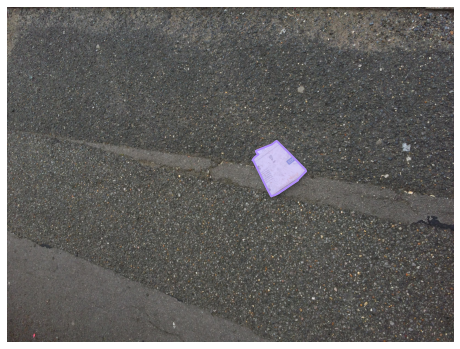

In [8]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [9]:
annIds

[261]

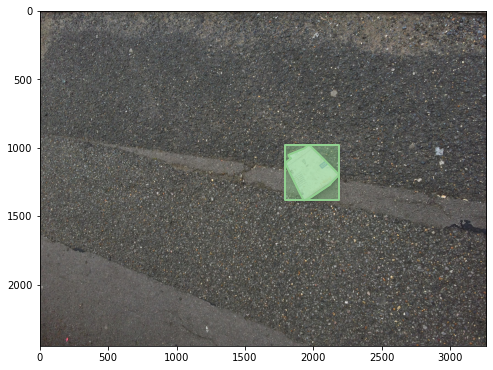

In [10]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

### 2. Train chosen model with parameters:
- from sctrach with 1 or 6 classes
- fine tuned model detr50 with 1 or 6 classes and with AdamW and LaProp Optimizer: https://github.com/facebookresearch/detr/issues/9

### 2.1 Things to change:
- the parameter name ```num_classes``` is misleading. It is actually the ID which DETR will reserve for its own no_object class. It should be set to one plus the highest class ID in your dataset. It has to be changed in ```models/detr.py``` in 313 line
- dataset to load: create function ```build_taco()``` with parameters in ```datasets/coco.py``` lines 146-157 and modify function build_dataset in ```datasets/__init__.py``` in line 21
- delete head of source model to enable classyfication of proper number of class in ```main.py```
- add new optimizer ```LaProp class``` in util directory

In [5]:
# training from sctrach
import sys
sys.path.append('/dih4/dih4_home/smajchrowska/detr/util/')

from util.plot_utils import *
from pathlib import Path, PurePath

ModuleNotFoundError: No module named 'util'

In [6]:
fields = ('loss','class_error','loss_bbox','loss_giou','mAP')  # <-- I put the items of interest here

### 3.1 Training from sctrach

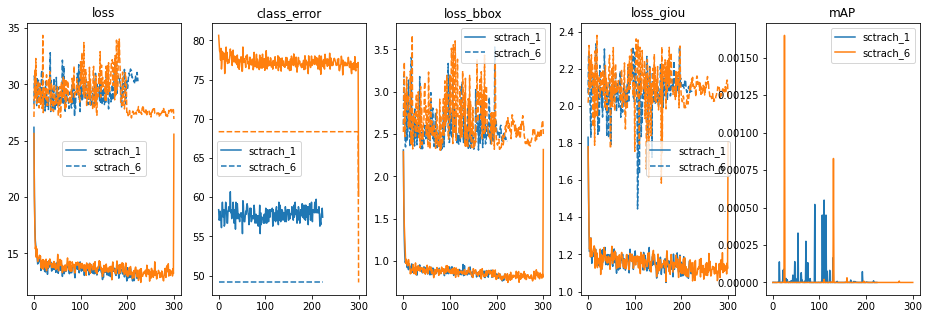

In [13]:
plot_logs([Path('/dih4/dih4_home/smajchrowska/detr/sctrach_1'), Path('/dih4/dih4_home/smajchrowska/detr/sctrach_6')], fields, save=False)

### 3.2 Fine tuned model

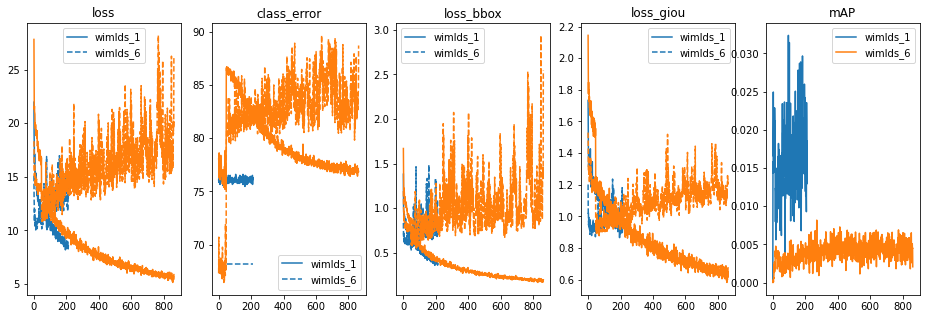

In [17]:
# finetuning first attempt: 1 or 6 classes with ResNet50 and AdamW
plot_logs([Path('/dih4/dih4_home/smajchrowska/detr/wimlds_1'), Path('/dih4/dih4_home/smajchrowska/detr/wimlds_6')], fields, save=False)

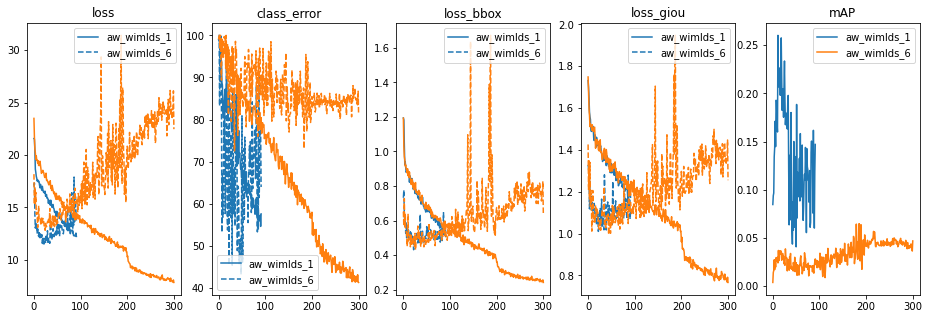

In [18]:
# finetuning second attempt: 1 or 6 classes with ResNet50 and AdamW
plot_logs([Path('/dih4/dih4_home/smajchrowska/detr/aw_wimlds_1'), Path('/dih4/dih4_home/smajchrowska/detr/aw_wimlds_6')], fields, save=False)

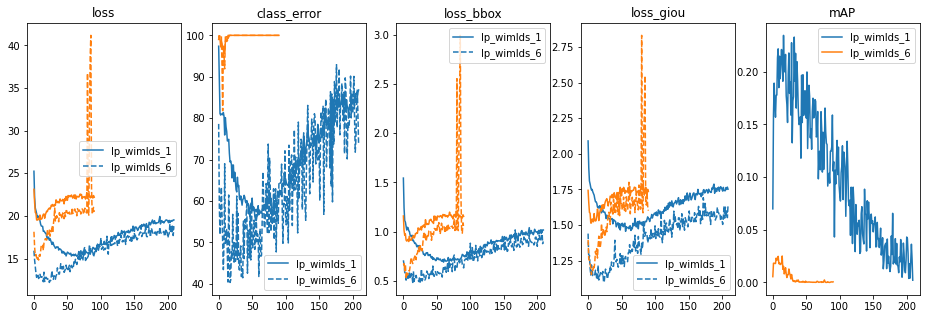

In [19]:
# finetuning third attempt: 1 or 6 classes with ResNet50 and LaProp
plot_logs([Path('/dih4/dih4_home/smajchrowska/detr/lp_wimlds_1'), Path('/dih4/dih4_home/smajchrowska/detr/lp_wimlds_6')], fields, save=False)

### 3.3 Check results...

In [4]:
# TACO classes
CLASSES_6 = [
    'Glass', 'Metals and plastics', 'Non recyclable', 'Other', 'Paper', 'Bio'
]

CLASSES_1 = [
    'Litter'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [12]:
import math
import torchvision.transforms as T
import torch
torch.set_grad_enabled(False);

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes, CLASSES=CLASSES_6, COLORS=COLORS):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def id2rgb(id_map):
    if isinstance(id_map, np.ndarray):
        id_map_copy = id_map.copy()
        rgb_shape = tuple(list(id_map.shape) + [3])
        rgb_map = np.zeros(rgb_shape, dtype=np.uint8)
        for i in range(3):
            rgb_map[..., i] = id_map_copy % 256
            id_map_copy //= 256
        return rgb_map
    color = []
    for _ in range(3):
        color.append(id_map % 256)
        id_map //= 256
    return color

In [13]:
segment = True
num_classes = 1

if not segment:
    model = torch.hub.load('facebookresearch/detr',
                           'detr_resnet50',
                           pretrained=False,
                           num_classes=num_classes)
    checkpoint = torch.load(f'/dih4/dih4_home/smajchrowska/detr/aw_wimlds_{num_classes}/checkpoint.pth',
                            map_location='cpu')
else:
    model, postprocessor = torch.hub.load('facebookresearch/detr',
                                          'detr_resnet101_panoptic',
                                          pretrained=False, return_postprocessor=True,
                                          num_classes=num_classes)
    checkpoint = torch.load(f'/dih4/dih4_2/wimlds/smajchrowska/detr_mask/checkpoint0014.pth',
                        map_location='cpu')





model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /home/smajchrowska/.cache/torch/hub/facebookresearch_detr_master


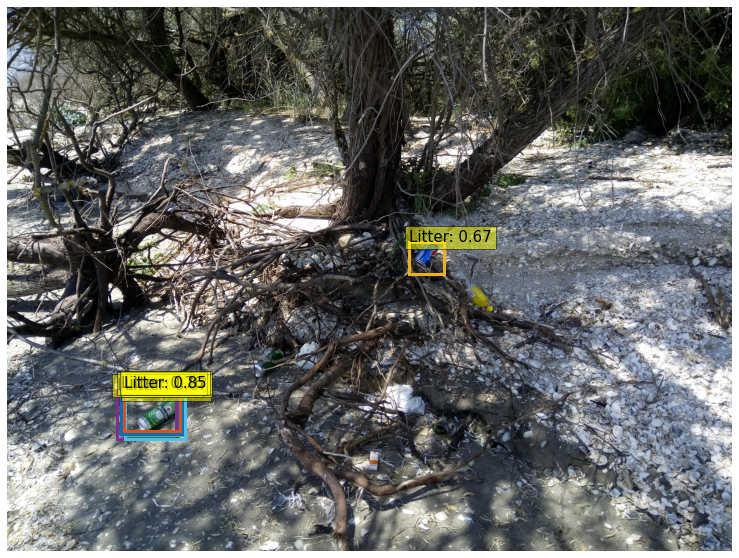

In [14]:
from PIL import Image

img_name = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/000344.jpg'
# problems
#img_name = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/001290.jpg'
#img_name = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/000069.jpg'
#img_name = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/001203.jpg'
im = Image.open(img_name)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.x+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.3

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled, CLASSES=CLASSES_1)

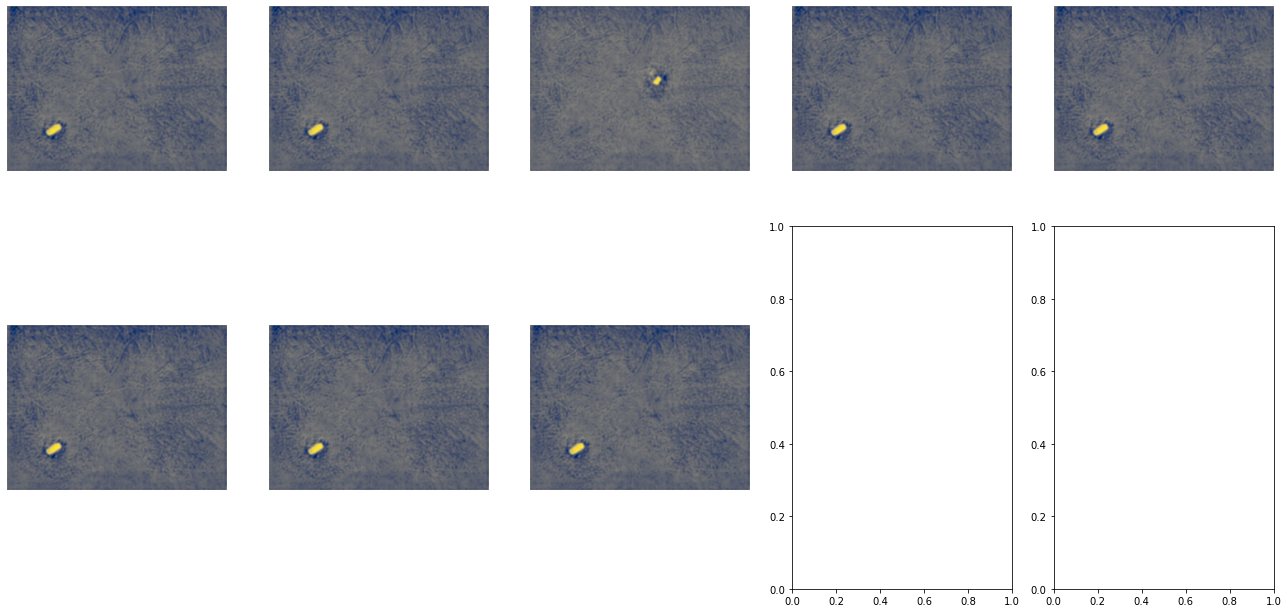

In [15]:
# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
#for line in axs:
#    for a in line:
#        a.axis('off')
for i, mask in enumerate(outputs["pred_masks"][0, keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask, cmap="cividis")
    ax.axis('off')
fig.tight_layout()

In [16]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(outputs, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

NameError: name 'id2rgb' is not defined